<a href="https://colab.research.google.com/github/stevengregori92/GenerativeAdversarialNetwork/blob/main/WDCGAN_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install 'jcopdl<2.0'
!gdown https://drive.google.com/uc?id=1KaiwyyYRGW8FbvSd4Feg1i1YW2k2s30u
!unzip /content/celebA_redux.zip

Streaming output truncated to the last 5000 lines.
  inflating: celebA_redux/train/005787.png  
  inflating: __MACOSX/celebA_redux/train/._005787.png  
  inflating: celebA_redux/train/004499.png  
  inflating: __MACOSX/celebA_redux/train/._004499.png  
  inflating: celebA_redux/train/007190.png  
  inflating: __MACOSX/celebA_redux/train/._007190.png  
  inflating: celebA_redux/train/000827.png  
  inflating: __MACOSX/celebA_redux/train/._000827.png  
  inflating: celebA_redux/train/006701.png  
  inflating: __MACOSX/celebA_redux/train/._006701.png  
  inflating: celebA_redux/train/009432.png  
  inflating: __MACOSX/celebA_redux/train/._009432.png  
  inflating: celebA_redux/train/000370.png  
  inflating: __MACOSX/celebA_redux/train/._000370.png  
  inflating: celebA_redux/train/010163.png  
  inflating: __MACOSX/celebA_redux/train/._010163.png  
  inflating: celebA_redux/train/004116.png  
  inflating: __MACOSX/celebA_redux/train/._004116.png  
  inflating: celebA_redux/train/003679.p

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#Dataset & Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
bs=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #menjadi (-1, 1) agar stabil
])

train_set = datasets.ImageFolder('/content/celebA_redux', transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle = True, num_workers=2)

#Arsitektur & Config

In [6]:
%%writefile model_wdcgan.py

import torch
from torch import nn
from jcopdl.layers import conv_block, tconv_block, linear_block

def conv(c_in, c_out, batch_norm=True, activation='lrelu'):
  return conv_block(c_in, c_out, kernel=4, stride=2, pad=1, bias=False, batch_norm=batch_norm, activation=activation, pool_type=None)

def tconv(c_in, c_out, batch_norm=True, activation='lrelu'):
  return tconv_block(c_in, c_out, kernel=4, stride=2, pad=1, bias=False, batch_norm=batch_norm, activation=activation, pool_type=None)

class Critic(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      conv(3, 32, batch_norm=False),
      conv(32, 64),
      conv(64, 128),
      conv(128, 256),
      conv_block(256, 1, kernel=4, stride=1, pad=0, bias=False, activation=None, pool_type=None),
      nn.Flatten()
    )

  def forward(self, x):
    x = self.conv(x)
    return x

  def clip_weights(self, vmin = -0.01, vmax = 0.01):
    for p in self.parameters():
      p.data.clamp_(vmin, vmax)

class Generator(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim
    self.tconv = nn.Sequential(
      tconv_block(z_dim, 512, kernel=4, stride=2, pad=1, bias=False, activation='lrelu', pool_type=None),
      tconv(512, 256),
      tconv(256, 128),
      tconv(128, 64),
      tconv(64, 32),
      tconv(32, 3, activation='tanh', batch_norm=False),
    )

  def forward(self, x):
    return self.tconv(x)

  def generate(self, n, device):
    z = torch.randn((n, self.z_dim, 1, 1), device=device)
    return self.tconv(z)

Writing model_wdcgan.py


In [7]:
config = set_config({
    'z_dim' : 100,
    'batch_size': bs
})

#Training Preparation

In [8]:
from model_wdcgan import Critic, Generator

In [9]:
def wasserstein_loss(output, target):
  return output.mean()*target.mean()

In [10]:
D = Critic().to(device)
G = Generator(config.z_dim).to(device)

criterion = wasserstein_loss

d_optimizer = optim.RMSprop(D.parameters(), lr=1e-4)
g_optimizer = optim.RMSprop(G.parameters(), lr=1e-4)

#Training

In [11]:
!rm -rf /content/output

In [12]:
import os
from torchvision.utils import save_image

os.makedirs('output/WDCGAN/', exist_ok=True)
os.makedirs('model/WDCGAN/', exist_ok=True)

In [13]:
max_epochs = 300
for epoch in range(max_epochs):
  D.train()
  G.train()
  for i, (real_img, _) in enumerate(trainloader):
    n_data = real_img.shape[0]

    # Real and Fake Images
    real_img = real_img.to(device)
    fake_img = G.generate(n_data, device)

    # Real and Fake Labels
    real = -torch.ones((n_data, 1), device=device)
    fake = torch.ones((n_data, 1), device=device)

    ## Training Discriminator
    d_optimizer.zero_grad()
    # Real Image -> Discriminator -> Real Label
    output = D(real_img)
    d_real_loss = criterion(output, real)

    #Fake Image -> Discriminator -> Fake Label
    output = D(fake_img.detach())
    d_fake_loss = criterion(output, fake)

    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    ##Critic Weight Cliping
    D.clip_weights()

    if i % 5 ==0:
      ## Training Generator
      g_optimizer.zero_grad()
      #Fake image -> Discriminator -> Tapi label Real
      output = D(fake_img)
      g_loss = criterion(output, real)
      g_loss.backward()
      g_optimizer.step()

  if epoch % 5 == 0:
    print(f'Epoch: {epoch:5} | D_loss: {d_loss/2:.5f} | G_loss: {g_loss:.5f}')

  if epoch % 15 == 0:
    G.eval()
    epoch = str(epoch).zfill(4)
    fake_img = G.generate(64, device)
    save_image(fake_img, f'output/WDCGAN/{epoch}.jpg', nrow=8, normalize=True)

    torch.save(D, 'model/WDCGAN/critic.pth')
    torch.save(G, 'model/WDCGAN/generator.pth')

Epoch:     0 | D_loss: -0.18972 | G_loss: 0.18087
Epoch:     5 | D_loss: -0.27481 | G_loss: 0.28081
Epoch:    10 | D_loss: -0.28511 | G_loss: 0.30318
Epoch:    15 | D_loss: -0.22998 | G_loss: 0.24326
Epoch:    20 | D_loss: -0.21774 | G_loss: 0.23675
Epoch:    25 | D_loss: -0.16541 | G_loss: 0.27740
Epoch:    30 | D_loss: -0.17054 | G_loss: 0.15032
Epoch:    35 | D_loss: -0.16880 | G_loss: 0.10875
Epoch:    40 | D_loss: -0.14203 | G_loss: 0.24908
Epoch:    45 | D_loss: -0.11398 | G_loss: 0.09900
Epoch:    50 | D_loss: -0.12886 | G_loss: 0.21983
Epoch:    55 | D_loss: -0.12345 | G_loss: 0.08059
Epoch:    60 | D_loss: -0.12651 | G_loss: 0.07302
Epoch:    65 | D_loss: -0.11023 | G_loss: 0.18958
Epoch:    70 | D_loss: -0.10642 | G_loss: 0.21046
Epoch:    75 | D_loss: -0.11819 | G_loss: 0.02013
Epoch:    80 | D_loss: -0.10755 | G_loss: 0.05873
Epoch:    85 | D_loss: -0.09167 | G_loss: 0.19020
Epoch:    90 | D_loss: -0.09670 | G_loss: 0.19688
Epoch:    95 | D_loss: -0.08509 | G_loss: 0.20198


In [14]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/WDCGAN/ (stored 0%)
  adding: content/model/WDCGAN/generator.pth (deflated 8%)
  adding: content/model/WDCGAN/critic.pth (deflated 33%)


In [15]:
from IPython.display import Image
from torchvision.utils import save_image

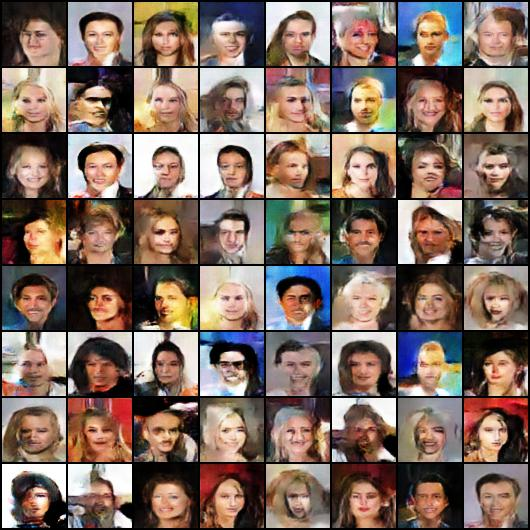

In [18]:
G = torch.load(f'model/WDCGAN/generator.pth', map_location='cuda').eval()
fake_img = G.generate(64, device)
save_image(fake_img, f'output/WDCGAN.jpg', nrow=8, normalize=True)
Image(f'output/WDCGAN.jpg')